In [1]:
from tool import *
import plotly.express as px
from openpyxl import Workbook
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.drawing.image import Image
from openpyxl.styles import PatternFill, Alignment, Font, Border, Side
# import matplotlib.pyplot as plt

In [2]:
with open('D:/Data/Shipment Plan_Adjusted_new.DB', 'rb') as f:
    spdb = pickle.load(f)
with open('D:/Data/contact_window.db', 'rb') as f:
    cont = pickle.load(f)

In [3]:
spdb.groupby(['Planweek', 'Category'])['Created_at'].unique().apply(lambda x:len(x)).unstack('Planweek').fillna(0).astype(int).replace({0:'None'})

Planweek,2023-07-31(W31),2023-08-07(W32),2023-08-14(W33),2023-08-21(W34),2023-08-28(W35),2023-09-04(W36),2023-09-11(W37)
Category,,,,,,,
Final26w,1,1,1,1,1,1,1
Final52w,1,1,1,1,1,1,1
Latest26w,None,None,None,None,None,None,2


In [4]:
spdb.groupby(['Planweek', 'Category', 'Created_at']).sum('SP').reset_index().iloc[-16:, ] # 선택할 SP의 Version 목록을 출력

,Planweek,Category,Created_at,SP
0,2023-07-31(W31),Final26w,202309081208,567327.0
1,2023-07-31(W31),Final52w,202309081352,817902.0
2,2023-08-07(W32),Final26w,202309081208,615164.0
3,2023-08-07(W32),Final52w,202309081353,897809.0
4,2023-08-14(W33),Final26w,202309081210,625277.0
5,2023-08-14(W33),Final52w,202309081354,920554.0
6,2023-08-21(W34),Final26w,202309081211,722693.0
7,2023-08-21(W34),Final52w,202309081354,1029172.0
8,2023-08-28(W35),Final26w,202309081213,785053.0
9,2023-08-28(W35),Final52w,202309081355,1075029.0


In [15]:
i1 = 12 # 신규 SP의 위치
i2 = 10 # 비교할 대상의 위치

p_wk = spdb.groupby(['Planweek', 'Category', 'Created_at']).sum('SP').reset_index().iloc[i1, :4]['Planweek']
sp1 = spdb.merge(spdb.groupby(['Planweek', 'Category', 'Created_at']).sum('SP').reset_index().iloc[[i1], :3])
sp2 = spdb.merge(spdb.groupby(['Planweek', 'Category', 'Created_at']).sum('SP').reset_index().iloc[[i2], :3])

sp = pd.concat([sp1, sp2])
sp['Month'] = sp['Week Name'].apply(lambda x:f'{datetime.date.fromisoformat(x[:10]).isocalendar().year}-{get_month_from_date(datetime.date.fromisoformat(x[:10])):02d}')

with open('D:/Data/sitemap.db', 'rb') as f:
    site = pickle.load(f)

# IT ODM 모델명에서 시리즈명 추출
c1 = sp['From Site'].str.contains('AUO|TPV|TCL') # 모니터 ODM 일 경우
c2 = sp['Mapping Model.Suffix'].str.match('\d{2}[T|Z|U|A][G|D|N|W]?\d{2}[A-Z]{1,2}') # PC/태블릿 모델일 경우
c3 = sp['Mapping Model.Suffix'].str.contains('CL600') # 페가트론 CL600 모델일 경우

sp.loc[c1, 'Series'] = sp[c1]['Mapping Model.Suffix'].apply(lambda x:x[:2]) # 모니터 모델의 시리즈명(inch) 추출
sp.loc[c2, 'Series'] = sp[c2]['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).str.replace('D|G|N|W|C', '').apply(lambda x:x[:6]) # PC모델의 대표모델명 추출
sp.loc[c3, 'Series'] = 'CL600'

sp = pd.merge(sp, site[['To Site', 'Subsidiary', 'Country']], how='left')
sp = sp.fillna('N/A')

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_18280\2589807033.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  sp.loc[c2, 'Series'] = sp[c2]['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).str.replace('D|G|N|W|C', '').apply(lambda x:x[:6]) # PC모델의 대표모델명 추출


In [16]:
sp = sp[sp['From Site'].str.contains('TPV|TCL')]
sp = sp[sp['Month'].isin(['2023-09', '2023-10'])]
gap = sp.groupby(['Planweek', 'From Site', 'Month', 'Week Name', 'Series'])['SP'].sum().unstack(['Planweek']).fillna(0).astype(int)
gap['Gap'] = gap[gap.columns[-1]] - gap[gap.columns[0]]
# gap_vendor = gap_vendor.unstack('Month').fillna(0).astype(int)
# gap_vendor['Sum of Gap'] = gap_vendor['Gap'].sum(axis=1)
# gap_vendor.loc[('', 'Sum'), :] = gap_vendor.sum()
# gap_vendor = gap_vendor.astype(int)

In [17]:
gap.unstack('Month')

Planweek                                    2023-09-04(W36)  2023-09-11(W37)  \
From Site   Month   Week Name       Series                                     
OS_TCL_CN_P 2023-09 2023-09-04(W36) 22                 1680              840   
                    2023-09-11(W37) 22                    0              840   
                    2023-09-18(W38) 22                 6216             6216   
                                    24                 4960             4960   
                                    27                 5376             5376   
                    2023-09-25(W39) 22                 1260             1260   
                                    27                 9216             9216   
            2023-10 2023-10-02(W40) 22                 2240             2240   
                                    24                  800              800   
                                    27                20352            20352   
                    2023-10-09(W41) 22                 9296             2464   
                                    24                10548             5728   
                                    27                12624             4832   
                    2023-10-16(W42) 22                 9324            10298   
                                    24                 5600             7220   
                                    27                 1152             7759   
                    2023-10-23(W43) 22                 5348             9421   
                                    24                 5386             6426   
                                    27                 6202             5377   
OS_TPV_CN_P 2023-09 2023-09-11(W37) 32                    0                2   
                    2023-09-18(W38) 32                  600              600   
                    2023-09-25(W39) 24                19440            22640   
                                    32                 9552             8128   
            2023-10 2023-10-02(W40) 24                20416            17216   
                                    32                 9996             9620   
                    2023-10-09(W41) 24                13600             1600   
                                    32                 6160             3000   
                    2023-10-16(W42) 24                 4705            12753   
                                    32                 5152             8441   
                    2023-10-23(W43) 24                 4035             4624   
                                    32                 6448             6336   

Planweek                                      Gap  
From Site   Month   Week Name       Series         
OS_TCL_CN_P 2023-09 2023-09-04(W36) 22       -840  
                    2023-09-11(W37) 22        840  
                    2023-09-18(W38) 22          0  
                                    24          0  
                                    27          0  
                    2023-09-25(W39) 22          0  
                                    27          0  
            2023-10 2023-10-02(W40) 22          0  
                                    24          0  
                                    27          0  
                    2023-10-09(W41) 22      -6832  
                                    24      -4820  
                                    27      -7792  
                    2023-10-16(W42) 22        974  
                                    24       1620  
                                    27       6607  
                    2023-10-23(W43) 22       4073  
                                    24       1040  
                                    27       -825  
OS_TPV_CN_P 2023-09 2023-09-11(W37) 32          2  
                    2023-09-18(W38) 32          0  
                    2023-09-25(W39) 24       3200  
                                    32      -1424  
            2023-10 2023-10-02(W40) 24      -3200  
       

In [36]:


gap_vendor = sp.groupby(['Planweek', 'Created_at', 'Division', 'From Site', 'Category', 'Month'])['SP'].sum().unstack(['Planweek', 'Category', 'Created_at']).fillna(0).astype(int)
gap_vendor['Gap'] = gap_vendor[gap_vendor.columns[-1]] - gap_vendor[gap_vendor.columns[0]]
gap_vendor = gap_vendor.unstack('Month').fillna(0).astype(int)
gap_vendor['Sum of Gap'] = gap_vendor['Gap'].sum(axis=1)
gap_vendor.loc[('', 'Sum'), :] = gap_vendor.sum()
gap_vendor = gap_vendor.astype(int)

gap_region = sp.groupby(['Planweek', 'Created_at', 'From Site', 'Region', 'Category', 'Month'])['SP'].sum().unstack(['Planweek', 'Category', 'Created_at']).fillna(0).astype(int)
gap_region['Gap'] = gap_region[gap_region.columns[-1]] - gap_region[gap_region.columns[0]]
gap_region = gap_region.unstack('Month').fillna(0).astype(int)
gap_region['Sum of Gap'] = gap_region['Gap'].sum(axis=1)
gap_region.loc[('', 'Sum'), :] = gap_region.sum()
gap_region = gap_region.astype(int)

gap_series = sp.groupby(['Planweek', 'Created_at', 'From Site', 'Series', 'Category', 'Month'])['SP'].sum().unstack(['Planweek', 'Category', 'Created_at']).fillna(0).astype(int)
gap_series['Gap'] = gap_series[gap_series.columns[-1]] - gap_series[gap_series.columns[0]]
gap_series = gap_series.unstack('Month').fillna(0).astype(int)
gap_series['Sum of Gap'] = gap_series['Gap'].sum(axis=1)
gap_series.loc[('', 'Sum'), :] = gap_series.sum()
gap_series = gap_series.astype(int)

gap_country = sp.groupby(['Planweek', 'Created_at', 'From Site', 'Region', 'Subsidiary', 'Country', 'To Site', 'Category', 'Series', 'Week Name', 'Month'])['SP'].sum().unstack(['Planweek', 'Category', 'Created_at']).fillna(0).astype(int)
gap_country['Gap'] = gap_country[gap_country.columns[-1]] - gap_country[gap_country.columns[0]]
gap_country = gap_country.unstack(['Month']).fillna(0).astype(int)
gap_country['Sum'] = gap_country['Gap'].sum(axis=1)
gap_country = gap_country.astype(int)

# gap = sp.groupby(['Planweek', 'Created_at', 'From Site', 'Inch', 'Region', 'Subsidiary', 'Country', 'To Site', 'Category', 'Week Name', 'Month', 'SCM', 'MKT'])['SP'].sum().unstack(['Planweek', 'Category', 'Created_at']).fillna(0).astype(int)
# gap['Gap'] = gap[gap.columns[-1]] - gap[gap.columns[0]]
# gap_inch_country = gap.unstack(['Month']).fillna(0).astype(int)
# gap_inch_country['Sum of Gap'] = gap_inch_country['Gap'].sum(axis=1)
# gap_inch_country = gap_inch_country.astype(int)

c2 = sp['Created_at'] == spdb.groupby(['Planweek', 'Category', 'Created_at']).sum('SP').reset_index().iloc[i1, :3]['Created_at']
c3 = sp['Created_at'] == spdb.groupby(['Planweek', 'Category', 'Created_at']).sum('SP').reset_index().iloc[i2, :3]['Created_at']
sp1 = sp[c2].pivot_table('SP', index=['From Site', 'Division', 'Region', 'Subsidiary', 'Country', 'To Site', 'Series', 'Mapping Model.Suffix', 'Rep PMS'], columns='Week Name', aggfunc=sum).fillna(0).astype(int)
wk = sp1.columns[0]
while wk < sp1.columns[-1]:
    if get_weekname_from(wk, 1) not in sp1.columns:
        sp1.insert(sp1.columns.get_loc(wk) + 1, get_weekname_from(wk, 1), 0)
    wk = get_weekname_from(wk, 1)
sp2 = sp[c3].pivot_table('SP', index=['From Site', 'Division', 'Region', 'Subsidiary', 'Country', 'To Site', 'Series', 'Mapping Model.Suffix', 'Rep PMS'], columns='Week Name', aggfunc=sum).fillna(0).astype(int)
wk = sp2.columns[0]
while wk < sp2.columns[-1]:
    if get_weekname_from(wk, 1) not in sp2.columns:
        sp2.insert(sp2.columns.get_loc(wk) + 1, get_weekname_from(wk, 1), 0)
    wk = get_weekname_from(wk, 1)
    
dataset = spdb[spdb['Category'].str.contains('Final26w')].copy()
dataset = pd.merge(dataset, dataset.groupby(['Planweek', 'Category'])['Created_at'].max().reset_index())
# IT ODM 모델명에서 시리즈명 추출
c1 = dataset['From Site'].str.contains('AUO|TPV|TCL') # 모니터 ODM 일 경우
c2 = dataset['Mapping Model.Suffix'].str.match('\d{2}[T|Z|U|A][G|D|N|W|C]?\d{2}[A-Z]{1,2}') # PC/태블릿 모델일 경우
c3 = dataset['Mapping Model.Suffix'].str.contains('CL600') # 페가트론 CL600 모델일 경우

dataset.loc[c1, 'Series'] = dataset[c1]['Mapping Model.Suffix'].apply(lambda x:x[:2]) # 모니터 모델의 시리즈명(inch) 추출
dataset.loc[c2, 'Series'] = dataset[c2]['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).str.replace('D|G|N|W|C', '').apply(lambda x:x[:6]) # PC모델의 대표모델명 추출
dataset.loc[c3, 'Series'] = 'CL600'

dataset['Month'] = dataset['Week Name'].apply(lambda x:f'{datetime.date.fromisoformat(x[:10]).isocalendar().year}-{get_month_from_date(datetime.date.fromisoformat(x[:10])):02d}')
wklist = dataset['Planweek'].unique()
sp_all = dataset[dataset['Planweek'] == wklist[0]].copy()
for curr_week in wklist[1:]:
    curr_week_sp = dataset[dataset['Planweek'] == curr_week].copy()
    curr_wklist = curr_week_sp['Week Name'].unique()
    exclude_cond1 = sp_all['Planweek'] == sp_all['Planweek'].max()
    exclude_cond2 = ~sp_all['Week Name'].isin(curr_wklist)
    exclude_cond3 = sp_all['Week Name'] < sp_all['Planweek'].max()
    curr_week_sp = pd.concat([sp_all[exclude_cond1 & exclude_cond2 & exclude_cond3], curr_week_sp]).reset_index(drop=True)
    curr_week_sp['Planweek'] = curr_week
    sp_all = pd.concat([sp_all, curr_week_sp]).reset_index(drop=True)

row_num = 1
filepath_to_save = f"D:/MNT/ODM_SP/SP_GAP/{p_wk}_IT_ODM_SP_Review_{datetime.datetime.now().strftime('%y%m%d%H%M')}.xlsx"
with pd.ExcelWriter(filepath_to_save) as writer:
    gap_vendor.to_excel(writer, sheet_name='Summary', startrow=row_num)
    table_height = gap_vendor.shape[0] + len(gap_vendor.columns[0]) + 1 + 1
    row_num = row_num + table_height
    gap_region.to_excel(writer, sheet_name='Summary', startrow=row_num)
    table_height = gap_region.shape[0] + len(gap_region.columns[0]) + 1 + 1
    row_num = row_num + table_height
    gap_series.to_excel(writer, sheet_name='Summary', startrow=row_num)
    gap_country.to_excel(writer, sheet_name='Gap_by_country', startrow=1)
    sp1.to_excel(writer, sheet_name=spdb.groupby(['Planweek', 'Category', 'Created_at']).sum('SP').reset_index().iloc[i1, :3]['Planweek'], startrow=1, merge_cells=False)
    sp2.to_excel(writer, sheet_name=spdb.groupby(['Planweek', 'Category', 'Created_at']).sum('SP').reset_index().iloc[i2, :3]['Planweek'], startrow=1, merge_cells=False)

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_20160\566690989.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  sp.loc[c2, 'Series'] = sp[c2]['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).str.replace('D|G|N|W|C', '').apply(lambda x:x[:6]) # PC모델의 대표모델명 추출
C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_20160\566690989.py:89: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset.loc[c2, 'Series'] = dataset[c2]['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).str.replace('D|G|N|W|C', '').apply(lambda x:x[:6]) # PC모델의 대표모델명 추출


In [37]:
sp = sp[sp['From Site'].str.contains('TCL|TPV')]

In [38]:
sp = sp[sp['Month'].isin(['2023-09', '2023-10'])]

In [48]:
gap = sp.groupby(['Planweek', 'From Site', 'Region', 'Month', 'Week Name']).sum().unstack(['Planweek']).fillna(0).astype(int)
gap['Gap'] = gap[gap.columns[-1]] - gap[gap.columns[0]]
gap = gap.unstack(['Month', 'Week Name']).fillna(0).astype(int)
gap['Sum of Gap'] = gap['Gap'].sum(axis=1)
gap.loc[('', 'Sum'), :] = gap.sum()
gap = gap.astype(int)

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_20160\282250274.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gap = sp.groupby(['Planweek', 'From Site', 'Region', 'Month', 'Week Name']).sum().unstack(['Planweek']).fillna(0).astype(int)


In [50]:
gap.to_clipboard()

In [123]:
wb = load_workbook(filepath_to_save)
color = PatternFill(fgColor='9999FF', fill_type='solid') # Blue
big_size = Font(name='맑은 고딕', size=20, bold=True, color='000099')
middle_size = Font(name='맑은 고딕', size=15, bold=True, color='000099')

border_style = Side(border_style="thin", color="000000")
border = Border(top=border_style, right=border_style, bottom=border_style, left=border_style)

In [124]:
sh = wb[wb.sheetnames[0]]
sh['A1'] = f'■ {p_wk} IT ODM Shipment Plan Review'
sh['A1'].font = big_size
min_row_num = 2
height_gap_region = len(gap_vendor.columns[0])
max_row_num = min_row_num + height_gap_region - 1
for row in sh.iter_rows(min_row=min_row_num, min_col=2, max_row=max_row_num, max_col=sh.max_column):
    for cell in row:
        cell.fill = color
merge_range = f'{get_column_letter(sh.max_column)}{min_row_num}:{get_column_letter(sh.max_column)}{max_row_num}'
sh.merge_cells(merge_range)
for cell in sh[merge_range][0]:
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)

min_row_num = max_row_num + 1
for row in sh.iter_rows(min_row=min_row_num, min_col=1, max_row=min_row_num, max_col=2):
    for cell in row:
        cell.fill = color

min_row_num = min_row_num + 1
max_row_num = min_row_num + gap_vendor.shape[0] - 1
for row in sh.iter_rows(min_row=min_row_num, min_col=3, max_row=max_row_num, max_col=sh.max_column):
    for cell in row:
        cell.border = border
        cell.number_format = '#,##0;[RED]Δ#,##0;"-"'

min_row_num = max_row_num + 2
height_gap_region = len(gap_region.columns[0])
max_row_num = min_row_num + height_gap_region - 1
for row in sh.iter_rows(min_row=min_row_num, min_col=2, max_row=max_row_num, max_col=sh.max_column):
    for cell in row:
        cell.fill = color
merge_range = f'{get_column_letter(sh.max_column)}{min_row_num}:{get_column_letter(sh.max_column)}{max_row_num}'
sh.merge_cells(merge_range)
for cell in sh[merge_range][0]:
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)

min_row_num = max_row_num + 1
for row in sh.iter_rows(min_row=min_row_num, min_col=1, max_row=min_row_num, max_col=2):
    for cell in row:
        cell.fill = color
        
min_row_num = min_row_num + 1
max_row_num = min_row_num + gap_region.shape[0] - 1
for row in sh.iter_rows(min_row=min_row_num, min_col=3, max_row=max_row_num, max_col=sh.max_column):
    for cell in row:
        cell.border = border
        cell.number_format = '#,##0;[RED]Δ#,##0;"-"'

min_row_num = max_row_num + 2
height_gap_series = len(gap_series.columns[0])
max_row_num = min_row_num + height_gap_series - 1
for row in sh.iter_rows(min_row=min_row_num, min_col=2, max_row=max_row_num, max_col=sh.max_column):
    for cell in row:
        cell.fill = color
merge_range = f'{get_column_letter(sh.max_column)}{min_row_num}:{get_column_letter(sh.max_column)}{max_row_num}'
sh.merge_cells(merge_range)
for cell in sh[merge_range][0]:
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
    
min_row_num = max_row_num + 1
for row in sh.iter_rows(min_row=min_row_num, min_col=1, max_row=min_row_num, max_col=2):
    for cell in row:
        cell.fill = color

min_row_num = min_row_num + 1
max_row_num = min_row_num + gap_series.shape[0] - 1
for row in sh.iter_rows(min_row=min_row_num, min_col=3, max_row=max_row_num, max_col=sh.max_column):
    for cell in row:
        cell.border = border
        cell.number_format = '#,##0;[RED]Δ#,##0;"-"'

sh.freeze_panes = 'C7'
sh.column_dimensions['A'].width = 15
sh.column_dimensions['B'].width = 15

In [125]:
sh = wb[wb.sheetnames[1]]
sh['A1'] = f'■ IT ODM Shipment Gap by Country'
sh['A1'].font = middle_size
sh['G1'] = 'Sub TTL'
for i in range(8, sh.max_column+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}7:{col_letter}{sh.max_row})'
    sh.cell(row=1, column=i).border = border
    sh.cell(row=1, column=i).number_format = '#,##0;[RED]Δ#,##0;"-"'
for row in sh.iter_rows(min_row=2, min_col=len(gap_country.index[0]) ,max_row=2+len(gap_country.columns[0])-1, max_col=sh.max_column):
    for cell in row:
        cell.fill = color
for row in sh.iter_rows(min_row=6, min_col=1 ,max_row=6, max_col=len(gap_country.index[0])):
    for cell in row:
        cell.fill = color
for row in sh.iter_rows(min_row=7, min_col=8, max_row=sh.max_row, max_col=sh.max_column):
    for cell in row:
        cell.border = border
        cell.number_format = '#,##0;[RED]Δ#,##0;"-"'
sh.freeze_panes = 'H7'
sh.column_dimensions['A'].width = 15
sh.column_dimensions['D'].width = 17.7
sh.column_dimensions['G'].width = 10

In [126]:
sh = wb[wb.sheetnames[2]]
sh['A1'] = f'■ {p_wk} IT ODM Shipment Plan'
sh['A1'].font = middle_size
sh['K1'] = 'Sub TTL'
for i in range(12, sh.max_column+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{sh.max_row})'
    sh.cell(row=1, column=i).border = border
    sh.cell(row=1, column=i).number_format = '#,##0;[RED]Δ#,##0;"-"'
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
for row in sh.iter_rows(min_row=3, min_col=12, max_row=sh.max_row, max_col=sh.max_column):
    for cell in row:
        cell.border = border
        cell.number_format = '#,##0;[RED]Δ#,##0;"-"'
sh.freeze_panes = 'L3'
sh.column_dimensions['A'].width = 10
sh.column_dimensions['E'].width = 13
sh.column_dimensions['F'].width = 14
sh.column_dimensions['G'].width = 5
sh.column_dimensions['I'].width = 18
sh.column_dimensions['K'].width = 4.25

In [127]:
sh = wb[wb.sheetnames[3]]
sh['A1'] = f'■ {get_weekname_from(p_wk, -1)} IT ODM Shipment Plan'
sh['A1'].font = middle_size
sh['N1'] = 'Sub TTL'
for i in range(12, sh.max_column+1):
    col_letter = get_column_letter(i)
    sh.cell(row=1, column=i).value = f'=subtotal(9, {col_letter}3:{col_letter}{sh.max_row})'
    sh.cell(row=1, column=i).border = border
    sh.cell(row=1, column=i).number_format = '#,##0;[RED]Δ#,##0;"-"'
for cell in sh[2]:
    cell.fill = color
    cell.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
for row in sh.iter_rows(min_row=3, min_col=12, max_row=sh.max_row, max_col=sh.max_column):
    for cell in row:
        cell.border = border
        cell.number_format = '#,##0;[RED]Δ#,##0;"-"'
sh.freeze_panes = 'L3'
sh.column_dimensions['A'].width = 10
sh.column_dimensions['E'].width = 13
sh.column_dimensions['F'].width = 14
sh.column_dimensions['G'].width = 5
sh.column_dimensions['I'].width = 18
sh.column_dimensions['K'].width = 4.25

In [128]:
wb.create_sheet('SP Variation')

def make_sp_variation(dataset, segment):
    sp_by_month = dataset.groupby(['Planweek', segment]).sum('SP').reset_index()
    sp_by_month = sp_by_month.sort_values(segment)
    x_sorted = np.sort(sp_by_month['Planweek'].unique())
    fig = px.bar(sp_by_month, x='Planweek', y='SP', color=segment, title=f'IT ODM Weekly SP total by {segment}', width=1500)
    return fig.update_xaxes(categoryarray=x_sorted)

segments = ['Division', 'From Site', 'Month', 'Region']
i = 2
for seg in segments:
    image_filepath = f'D:/figure/IT_ODM_weekly_sp_history_by_{seg}.png'
    make_sp_variation(sp_all, seg).write_image(image_filepath)
    sp_plot = Image(image_filepath)
    ws = wb['SP Variation']
    ws.add_image(sp_plot, f'A{i}')
    i = i+24

for name in wb.sheetnames:
    wb[name].sheet_view.showGridLines = False
    
wb.save(filepath_to_save)
wb.close()

In [132]:
make_sp_variation(sp_all, 'Division')

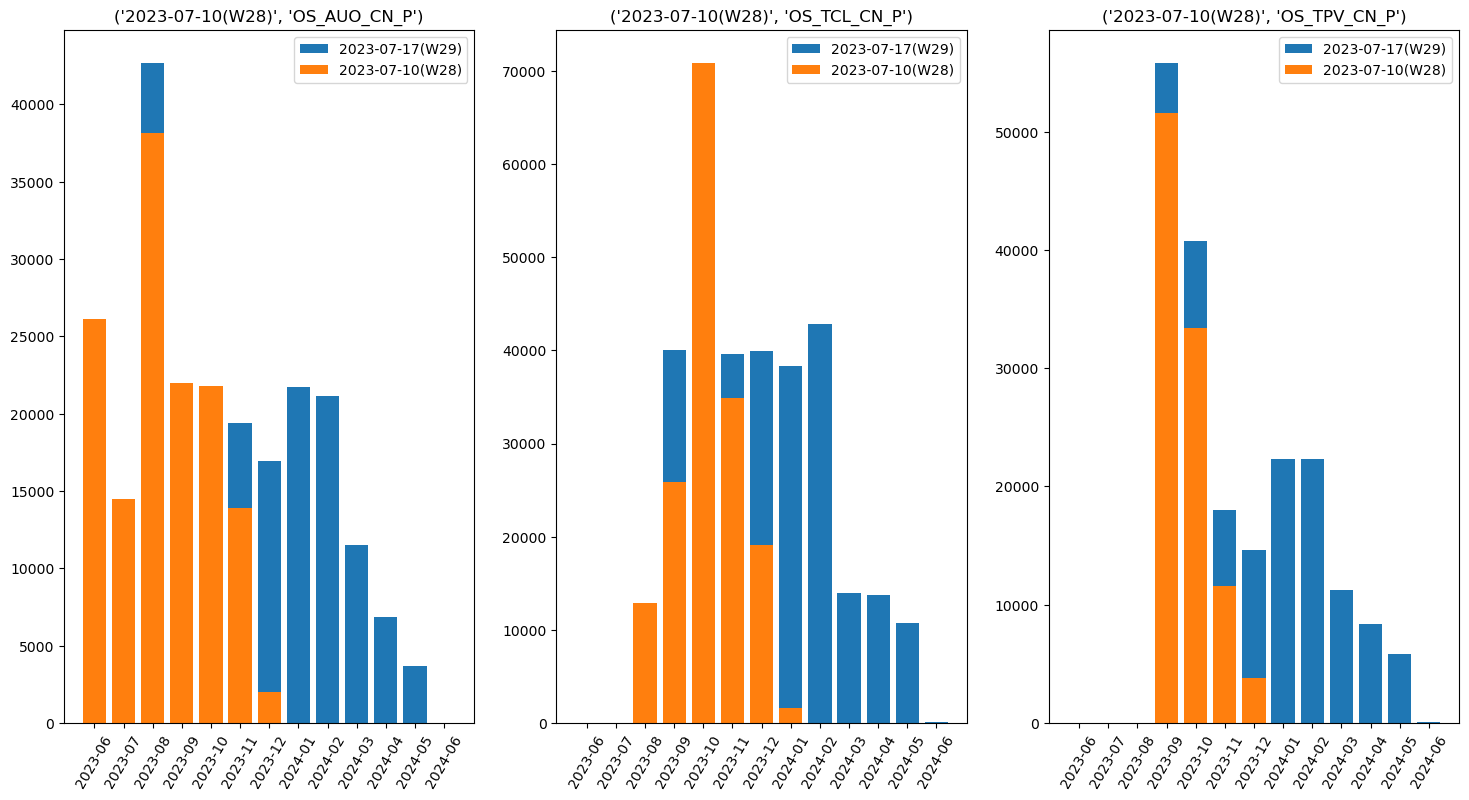

In [171]:
plt.figure(figsize=(18, 9))

for week in weeks:
    i = 1
    for site in sites:
        plt.subplot(1, len(sites), i)
        df = sp.groupby(['REF', 'From Site']).get_group((week, site)).groupby('Month')['QTY'].sum()
        plt.bar(df.index, df, label=week)
        plt.title(f'{week, site}')
        plt.xticks(rotation=60)
        plt.legend()
        i += 1
        
plt.show()

In [16]:
px.bar(sp, x='Month', y='QTY', color='REF', barmode='group')

In [14]:
gap_sp = get_difference_table(sp1.drop('REF', axis=1).set_index(['From Site', 'To Site', 'Region', 'Series', 'Inch', 'Mapping Model.Suffix']), sp2.drop('REF', axis=1).set_index(['From Site', 'To Site', 'Region', 'Series', 'Inch', 'Mapping Model.Suffix']), '\d-').reset_index()

In [73]:
sp

,REF,From Site,To Site,Region,Series,Inch,Month,QTY
0,2023-07-24(W30),OS_AUO_CN_P,EAIL,INDIA,24GQ50F,24,2023-06,0
1,2023-07-24(W30),OS_AUO_CN_P,EAIL,INDIA,24GQ50F,24,2023-07,0
2,2023-07-24(W30),OS_AUO_CN_P,EAIL,INDIA,24GQ50F,24,2023-08,1320
3,2023-07-24(W30),OS_AUO_CN_P,EAIL,INDIA,24GQ50F,24,2023-09,0
4,2023-07-24(W30),OS_AUO_CN_P,EAIL,INDIA,24GQ50F,24,2023-10,0
...,...,...,...,...,...,...,...,...
3123,2023-08-07(W32),OS_TPV_CN_P,ESCL_STG,SCA,32MR50C,32,2023-09,224
3124,2023-08-07(W32),OS_TPV_CN_P,ESCL_STG,SCA,32MR50C,32,2023-10,0
3125,2023-08-07(W32),OS_TPV_CN_P,ESCL_STG,SCA,32MR50C,32,2023-11,0
3126,2023-08-07(W32),OS_TPV_CN_P,ESCL_STG,SCA,32MR50C,32,2023-12,0


### SP자료 다운받은 폴더의 각 파일을 불러와 누적 SP 데이터프레임 만들기

### 1) 누적 SP의 초기값을 만듬

In [2]:


def accumulate_sp_history(total_sp, new_sp, idx_cols, ref_week):
    deleted_wk = []
    for wk in get_weeklist(total_sp):
        if wk not in get_weeklist(new_sp):
            deleted_wk.append(wk)
    org_idx = total_sp.reset_index().set_index(idx_cols).index
    new_idx = new_sp.reset_index().set_index(idx_cols).index
    intersecting_idx = org_idx.intersection(new_idx)
    diff_idx_org = org_idx.difference(intersecting_idx)
    
    find_most_recent_week = total_sp.reset_index()[['REF']+idx_cols].groupby(idx_cols)['REF'].max()
    idx_frame1 = find_most_recent_week[diff_idx_org].reset_index()[['REF'] + idx_cols]
    m_idx1 = pd.MultiIndex.from_frame(idx_frame1)
    add_df = total_sp.loc[m_idx1, :get_weekname_from(ref_week, -2)]
    for wk in find_most_recent_week[diff_idx_org].unique():
        if wk < get_weekname_from(ref_week, -1):
            add_df.loc[wk, wk:] = 0
            
    add_df = add_df[add_df.sum(axis=1) > 0]
    
    if len(deleted_wk) > 0:
        idx_frame2 = find_most_recent_week[intersecting_idx].reset_index()[['REF'] + idx_cols]
        idx_frame3 = idx_frame2.copy()
        idx_frame3['REF'] = ref_week
        m_idx2 = pd.MultiIndex.from_frame(idx_frame2)
        m_idx3 = pd.MultiIndex.from_frame(idx_frame3)
        new_sp.loc[m_idx3, deleted_wk] = total_sp.loc[m_idx2, deleted_wk].values
        
    new_sp = pd.concat([add_df, new_sp]).reset_index()
    new_sp['REF'] = ref_week
    new_sp = new_sp.set_index(['REF'] + idx_cols)
    
    return pd.concat([total_sp, new_sp])

In [3]:
# GSCP 자료를 저장한 폴더로 이동 후 최초 SP를 데이터프레임으로 저장
path = 'D:/Shipment Plan/MNT_GSCP/'
os.chdir(path)
filename = os.listdir()[0] # 최초의 SP에 대한 파일명
filepath = path + filename
col1 = ['From Site', 'To Site', 'Region', 'Mapping Model.Suffix'] # GSCP raw data에서 선택할 컬럼명
vendor = 'AUO'
ver = 'Final'
wk_name = filename[:15] # 해당 파일의 plan week

In [4]:
total_sp = read_sp_from_excel_gscp(filepath, vendor, wk_name, col1, ver)
total_sp

2021-08-30(W35)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2021-09-06(W36)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2021-09-13(W37)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2021-09-20(W38)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2021-09-27(W39)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2021-10-04(W40)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2021-10-11(W41)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2021-10-18(W42)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2021-10-25(W43)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2021-11-01(W44)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 ...  \
REF             From Site   To Site Region Mapping Model.Suffix  ...   
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ        ...   
                                           27GQ50F-B.AUSQ        ...   

                                                                 2022-02-07(W06)  \
REF             From Site   To Site Region Mapping Model.Suffix                    
2021-10-18(W42) OS_AUO_CN_P ENUS_V  NA     24GQ50F-B.AUSQ                      0   
                                           27GQ50F-B.AUSQ                      0   

                                                                 2022

In [5]:
for filename in tqdm(os.listdir()[1:]): # 엑셀 파일이 들어있는 폴더의 파일들 불러와 반복
    wk_name = filename[:15]
    filepath = path + filename
    sp = read_sp_from_excel_gscp(filepath, vendor, wk_name, col1, ver)
    total_sp = accumulate_sp_history(total_sp, sp, col1, wk_name)

  3%|██▊                                                                                | 3/90 [00:00<00:24,  3.53it/s]C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_1044\1856324515.py:25: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  add_df.loc[wk, wk:] = 0
  4%|███▋                                                                               | 4/90 [00:01<00:29,  2.91it/s]C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_1044\1856324515.py:25: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  add_df.loc[wk, wk:] = 0
  6%|████▌              

In [6]:
df = total_sp.reset_index()
df.insert(4, 'Series', df['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]))
df

,REF,From Site,To Site,Region,Series,Mapping Model.Suffix,2021-08-30(W35),2021-09-06(W36),2021-09-13(W37),2021-09-20(W38),...,2023-10-30(W44),2023-11-06(W45),2023-11-13(W46),2023-11-20(W47),2023-11-27(W48),2023-12-04(W49),2023-12-11(W50),2023-12-18(W51),2023-12-25(W52),2024-01-01(W01)
0,2021-10-18(W42),OS_AUO_CN_P,ENUS_V,NA,24GQ50F,24GQ50F-B.AUSQ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-18(W42),OS_AUO_CN_P,ENUS_V,NA,27GQ50F,27GQ50F-B.AUSQ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-25(W43),OS_AUO_CN_P,ENUS_V,NA,24GQ40W,24GQ40W-B.AUSQ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-25(W43),OS_AUO_CN_P,ENUS_V,NA,24GQ50F,24GQ50F-B.AUSQ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-25(W43),OS_AUO_CN_P,ENUS_V,NA,27GQ40W,27GQ40W-B.AUSQ,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459,2023-07-10(W28),OS_AUO_CN_P,ENUS_V,NA,27GQ40W,27GQ40W-B.AUSQ,0.0,0.0,0.0,0.0,...,2160.0,1080.0,1080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4460,2023-07-10(W28),OS_AUO_CN_P,ENUS_V,NA,27GQ50B,27GQ50B-B.AUBQ,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4461,2023-07-10(W28),OS_AUO_CN_P,ENUS_V,NA,27GQ50F,27GQ50F-B.AUSQ,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4462,2023-07-10(W28),OS_AUO_CN_P,ESCB,SCA,24GQ50F,24GQ50F-B.AWPQ,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
pd.concat([df['To Site'], df['To Site'].replace(site_map)], axis=1).drop_duplicates().to_clipboard()

In [20]:
df[['To Site', 'Region']].drop_duplicates().to_clipboard()

In [28]:
df1 = monthly_sum(df.groupby('REF').sum(numeric_only=True), 'REF')
df1 = df1.loc[:, df1.sum() != 0]
df1 = df1.stack().reset_index()
df1 = df1.rename(columns={'level_1':'Month', 0:'QTY'})
df1

KeyError: 'REF'

In [86]:
px.bar(df1, x='REF', y='QTY', color='Month')

In [70]:
df1 = monthly_sum(df.groupby('REF').sum(numeric_only=True), 'REF')
df1 = df1.loc[:, df1.sum() != 0]
df1 = df1.stack().reset_index()
df1 = df1.rename(columns={'level_1':'Month', 0:'QTY'})
df1

,REF,Month,QTY
0,2023-05-08(W19),2023-08,0.0
1,2023-05-08(W19),2023-09,1204.0
2,2023-05-08(W19),2023-10,416.0
3,2023-05-08(W19),2023-11,0.0
4,2023-05-08(W19),2023-12,0.0
5,2023-05-08(W19),2024-01,0.0
6,2023-05-15(W20),2023-08,11398.0
7,2023-05-15(W20),2023-09,18029.0
8,2023-05-15(W20),2023-10,5811.0
9,2023-05-15(W20),2023-11,600.0


In [31]:
col1 = ['Division', 'From Site', 'To Site', 'Region', 'Mapping Model.Suffix']
acc_sp = pd.read_excel('D:/SP현황/Init_SP/W01.xls', keep_default_na=False, na_values=['', 'nan']) # 기초 데이터프레임을 만들기 위한 파일경로명 설정
acc_sp = acc_sp[acc_sp['Category'].str.contains('Final Plan')]
trim_column_name(acc_sp)
wklist = get_weeklist(acc_sp)
acc_sp = acc_sp[col1+wklist]
wk_name = '2018-12-31(W01)'
acc_sp.insert(0, 'REF', wk_name)
acc_sp = acc_sp.groupby(['REF']+col1).sum()
wk_name = get_weekname_from(wk_name, 1)
acc_sp.head()

2018-12-03(W49)  \
REF             Division From Site        To Site Region Mapping Model.Suffix                    
2018-12-31(W01) PC       OS_PEGATRON_CN_P EKHQ    KOREA  13U580-G.AA50K                      0   
                                                         13U580-G.AR30K                      0   
                                                         13U580-L.AR10K                      0   
                                                         13UD580-G.AX30K                     0   
                                                         13UD580-G.AX50K                     0   

                                                                               2018-12-10(W50)  \
REF             Division From Site        To Site Region Mapping Model.Suffix                    
2018-12-31(W01) PC       OS_PEGATRON_CN_P EKHQ    KOREA  13U580-G.AA50K                      0   
                                                         13U580-G.AR30K                      0   
                                                         13U580-L.AR10K                      0   
                                                         13UD580-G.AX30K                     0   
                                                         13UD580-G.AX50K                     0   

                                                                               2018-12-17(W51)  \
REF             Division From Site        To Site Region Mapping Model.Suffix                    
2018-12-31(W01) PC       OS_PEGATRON_CN_P EKHQ    KOREA  13U580-G.AA50K                      0   
                                                         13U580-G.AR30K                    550   
                                                         13U580-L.AR10K                    720   
                                                         13UD580-G.AX30K                   105   
                                                         13UD580-G.AX50K                   190   

                                                                               2018-12-24(W52)  \
REF             Division From Site        To Site Region Mapping Model.Suffix                    
2018-12-31(W01) PC       OS_PEGATRON_CN_P EKHQ    KOREA  13U580-G.AA50K                    200   
                                                         13U580-G.AR30K                    450   
                                                         13U580-L.AR10K                    320   
                                                         13UD580-G.AX30K                   205   
                                                         13UD580-G.AX50K                   110   

                                                                               2018-12-31(W01)  \
REF             Division From Site        To Site Region Mapping Model.Suffix                    
2018-12-31(W01) PC       OS_PEGATRON_CN_P EKHQ    KOREA  13U580-G.AA50K                      0   
                                                         13U580-G.AR30K                      0   
                                                         13U580-L.AR10K                      0   
                                                         13UD580-G.AX30K                     0   
                                                         13UD580-G.AX50K                     0   

                                                                               2019-01-07(W02)  \
REF             Division From Site        To Site Region Mapping Model.Suffix                    
2018-12-31(W01) PC       OS_PEGATRON_CN_P EKHQ    KOREA  13U580-G.AA50K                      0   
                                                         13U580-G.AR30K                      0   
                                                         13U580-L.AR10K                      0   
                                                         13UD580-G.AX30K                     0   
                                                        

In [90]:
# Wingtech SP 변동현황 구하기
col1 = ['From Site', 'To Site', 'Mapping Model.Suffix']
acc_sp = pd.read_excel('D:/Downloads/2022_W15.xls', keep_default_na=False, na_values=['', 'nan']) # 기초 데이터프레임을 만들기 위한 파일경로명 설정
acc_sp = acc_sp[acc_sp['Category'].str.contains('Final Plan') & acc_sp['From Site'].str.contains('WING')]
trim_column_name(acc_sp)
wklist = get_weeklist(acc_sp)
acc_sp = acc_sp[col1+wklist]
wk_name = '2022-04-11(W15)'
acc_sp.insert(0, 'REF', wk_name)
acc_sp = acc_sp.groupby(['REF']+col1).sum()
wk_name = get_weekname_from(wk_name, 1)
acc_sp.head()

2022-03-07(W10)  \
REF             From Site        To Site Mapping Model.Suffix                    
2022-04-11(W15) OS_WINGTECH_CN_P EKHQ    10A30Q-L.AQ14K                      0   
                                         10A30Q-L.AQ14ML                     0   
                                         10A30Q-L.AQ28K                      0   
                                         10A30Q-L.AQ28ML                     0   
                                         10A30Q-L.AQ48KN                     0   

                                                               2022-03-14(W11)  \
REF             From Site        To Site Mapping Model.Suffix                    
2022-04-11(W15) OS_WINGTECH_CN_P EKHQ    10A30Q-L.AQ14K                      0   
                                         10A30Q-L.AQ14ML                     0   
                                         10A30Q-L.AQ28K                      0   
                                         10A30Q-L.AQ28ML                     0   
                                         10A30Q-L.AQ48KN                     0   

                                                               2022-03-21(W12)  \
REF             From Site        To Site Mapping Model.Suffix                    
2022-04-11(W15) OS_WINGTECH_CN_P EKHQ    10A30Q-L.AQ14K                      0   
                                         10A30Q-L.AQ14ML                     0   
                                         10A30Q-L.AQ28K                      0   
                                         10A30Q-L.AQ28ML                     0   
                                         10A30Q-L.AQ48KN                     0   

                                                               2022-03-28(W13)  \
REF             From Site        To Site Mapping Model.Suffix                    
2022-04-11(W15) OS_WINGTECH_CN_P EKHQ    10A30Q-L.AQ14K                      0   
                                         10A30Q-L.AQ14ML                     0   
                                         10A30Q-L.AQ28K                      0   
                                         10A30Q-L.AQ28ML                     0   
                                         10A30Q-L.AQ48KN                     0   

                                                               2022-04-04(W14)  \
REF             From Site        To Site Mapping Model.Suffix                    
2022-04-11(W15) OS_WINGTECH_CN_P EKHQ    10A30Q-L.AQ14K                      0   
                                         10A30Q-L.AQ14ML                     0   
                                         10A30Q-L.AQ28K                      0   
                                         10A30Q-L.AQ28ML                     0   
                                         10A30Q-L.AQ48KN                     0   

                                                               2022-04-11(W15)  \
REF             From Site        To Site Mapping Model.Suffix                    
2022-04-11(W15) OS_WINGTECH_CN_P EKHQ    10A30Q-L.AQ14K                      0   
                                         10A30Q-L.AQ14ML                     0   
                                         10A30Q-L.AQ28K                      0   
                                         10A30Q-L.AQ28ML                     0   
                                         10A30Q-L.AQ48KN                     0   

                                                               2022-04-18(W16)  \
REF             From Site        To Site Mapping Model.Suffix                    
2022-04-11(W15) OS_WINGTECH_CN_P EKHQ    10A30Q-L.AQ14K                      0   
                                         10A30Q-L.AQ14ML                     0   
                                         10A30Q-L.AQ28K                      0   
                                         10A30Q-L.AQ28ML                     0   
                                         10A30Q-L.AQ48KN                     0   

                                      

### 2) 반복을 위한 초기 조건 및 변수 세팅

In [44]:
dirname = f'D:/SP현황/2023/' 
os.chdir(dirname) # 다운받은 폴더로 이동

## 반복의 시작

In [45]:
for fn in tqdm(os.listdir()):
    path = dirname + fn # 다음 파일경로명 설정
    df = pd.read_excel(path, keep_default_na=False, na_values=['', 'nan'])
    df = df[df['Category'].str.contains('Final Plan') & df['From Site'].str.contains('PEGATRON')]
    trim_column_name(df)
    wklist = get_weeklist(df)
    deleted_wk = []
    for item in get_weeklist(acc_sp):
        if item not in get_weeklist(df):
            deleted_wk.append(item)

    df = df[col1+get_weeklist(df)]
    df.insert(0, 'REF', wk_name)
    df = df.groupby(['REF'] + col1).sum()
    
    org_idx = acc_sp.reset_index().set_index(col1).index
    new_idx = df.reset_index().set_index(col1).index
    intersecting_idx = org_idx.intersection(new_idx)
    diff_idx_org = org_idx.difference(intersecting_idx) # 첫 번째 인덱스에서 2번째 인덱스를 뺀 차집합 인덱스
    
    # 누적 데이터프레임에서 동일 index값이 가장 최근에 언제 주차에 있었는지 참조하기 위한 Series
    find_most_recent_week = acc_sp.reset_index()[['REF']+col1].groupby(col1)['REF'].max()
    idx_frame1 = find_most_recent_week[diff_idx_org].reset_index()[['REF'] + col1] # 누적 데이터프레임에서 가장 최근 주차의 행을 지정하기 위한 멀티인덱스를 만들기 위한 데이터프레임1
    m_idx1 = pd.MultiIndex.from_frame(idx_frame1) # 누적 데이터프레임에서 가장 최근 주차의 행을 지정하기 위한 idx
    add_df = acc_sp.loc[m_idx1, :get_weekname_from(wk_name, -1)]
    for w in find_most_recent_week[diff_idx_org]: # 누적 데이터프레임에서 차집합 인덱스를 반복하면서
        add_df.loc[w, w:] = 0                 # 해당 최근주차부터 이후 주차의 값은 '0' 으로 만듬(왜냐하면, 기존값은 실적이 아니므로)

    add_df = add_df[add_df.sum(axis=1) > 0]
    
    # deleted_wk 에 값이 있을 경우 df에 이전주차까지의 누적 데이터프레임의 삭제된 주차들의 선적 실적을 추가하는 작업
    if len(deleted_wk) > 0:
        idx_frame2 = find_most_recent_week[intersecting_idx].reset_index()[['REF']+col1] # 누적 데이터프레임에서 가장 최근 주차의 행을 지정하기 위한 멀티인덱스를 만들기 위한 데이터프레임1
        idx_frame3 = idx_frame2.copy() # 누적 데이터프레임에서 업데이트할 행을 지정하기 위한 멀티인덱스를 만들기 위한 데이터프레임2
        idx_frame3['REF'] = wk_name
        m_idx2 = pd.MultiIndex.from_frame(idx_frame2) # 누적 데이터프레임에서 가장 최근 주차의 행을 지정하기 위한 idx
        m_idx3 = pd.MultiIndex.from_frame(idx_frame3) # 누적 데이터프레임에서 업데이트할 행을 지정하기 위한 idx
        df.loc[m_idx3, deleted_wk] = acc_sp.loc[m_idx2, deleted_wk].values
    
    # 좀 전에 구한 누적 데이터프레임에는 있었는데 사라진 행들을 신규 데이터프레임과 합침 
    df = pd.concat([add_df, df]).reset_index()
    df['REF'] = wk_name
    df = df.set_index(['REF'] + col1)
    
    # df를 기존 누적 데이터프레임에 합침
    acc_sp = pd.concat([acc_sp, df])
    
    # wk_name을 다음주로 증가시킨뒤 처음으로 되돌아감
    wk_name = get_weekname_from(wk_name, 1)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.13s/it]


In [46]:
acc_sp.shape

(48035, 263)

In [73]:
acc_sp = acc_sp.reset_index()
acc_sp.insert(3, 'Series', acc_sp['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model))

In [56]:
with open('D:/Data/odm_forecast_history.db', 'rb') as f:
    acc_sp = pickle.load(f)

In [40]:
series = acc_sp['Series'].unique()
series = ['15U40Q']

In [41]:
tw = get_weekname(datetime.date.today()) # 이번주
acc_sp = acc_sp[acc_sp['REF'].isin([get_weekname_from(tw, i) for i in range(-10, 1)])]

In [38]:
df_plot = monthly_sum(acc_sp[acc_sp['Series'].isin(series)].groupby('REF').sum(numeric_only=False).reset_index(), 'REF')

NameError: name 'series' is not defined

In [96]:
df_plot = monthly_sum(acc_sp.groupby('REF').sum(numeric_only=True).reset_index(), 'REF')

In [59]:
df_plot = monthly_sum(acc_sp, 'REF')
df_plot = df_plot.loc[:, df_plot.sum() > 0]
df_plot

,2023-08,2023-09,2023-11
REF,,,
2023-05-08(W19),20.0,10.0,0.0
2023-05-15(W20),20.0,10.0,0.0
2023-05-22(W21),20.0,10.0,0.0
2023-05-29(W22),20.0,10.0,0.0
2023-06-05(W23),20.0,10.0,15.0


In [45]:
print(f'10A30Q의 SP 변동 데이터입니다.')
df_plot = monthly_sum(acc_sp[acc_sp['Series'].isin(series)].groupby('REF').sum(numeric_only=False).reset_index(), 'REF')
df_plot = df_plot.loc[:, df_plot.sum() > 0]
max_idx = df_plot.duplicated()
max_idx = max_idx[max_idx == False].index.max()
df_plot = df_plot.loc[:max_idx]
df_plot = df_plot.stack().reset_index()
df_plot.rename(columns={'level_1':'Month', 0:'QTY'}, inplace=True)
df_plot = df_plot[df_plot['Month'].isin(['2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09','2023-10', '2023-11'])]
fig = px.histogram(df_plot, x='REF', y='QTY', width=600, height=500, title = f'{series} SP History', text_auto='QTY')
fig.update_xaxes(tickangle=60)
fig.show()

['15U40Q']의 SP 변동 데이터입니다.


In [56]:
monthly_sum(acc_sp[acc_sp['Series'] == '13U580'].groupby('REF').sum(numeric_only=True).reset_index(), 'REF')

,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
REF,,,,,,,,,,,,,,,,,,,,,
2018-12-31(W01),3050.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-07(W02),3050.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-14(W03),3050.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-21(W04),3050.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-28(W05),3050.0,1360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22(W21),3050.0,1465.0,1795.0,440.0,60.0,1620.0,230.0,370.0,570.0,810.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-29(W22),3050.0,1465.0,1795.0,440.0,60.0,1620.0,230.0,370.0,570.0,810.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-05(W23),3050.0,1465.0,1795.0,440.0,60.0,1620.0,230.0,370.0,570.0,810.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
update_time = datetime.datetime.now().strftime('%y%m%d%H')
with pd.ExcelWriter(f'D:/Python result/{update_time}_odm_sp_history.xlsx') as writer:
    for num, name in enumerate(acc_sp['Series'].unique()):
        print(f'{num+1}_{name}의 SP 변동 이력 시각화 중 입니다.')
        df_plot = monthly_sum(acc_sp[acc_sp['Series'] == name].groupby('REF').sum(numeric_only=True).reset_index(), 'REF')
        df_plot.to_excel(writer, sheet_name=name, index=True)
        df_plot = df_plot.loc[:, df_plot.sum() > 0]
        max_idx = df_plot.duplicated()
        max_idx = max_idx[max_idx == False].index.max()
        df_plot = df_plot.loc[:max_idx]
        df_plot = df_plot.stack().reset_index()
        df_plot.rename(columns={'level_1':'Month', 0:'QTY'}, inplace=True)
        fig = px.bar(df_plot, x='REF', y='QTY', color='Month', width=1200, height=800, title = f'{name} SP History')
        fig.update_xaxes(tickangle=70)
        fig.write_image(f'D:/figure/{name}.png')        

1_13U70P의 SP 변동 이력 시각화 중 입니다.
2_14T90N의 SP 변동 이력 시각화 중 입니다.
3_17U70N의 SP 변동 이력 시각화 중 입니다.
4_17U70P의 SP 변동 이력 시각화 중 입니다.
5_13U50N의 SP 변동 이력 시각화 중 입니다.
6_14U30P의 SP 변동 이력 시각화 중 입니다.
7_14U390의 SP 변동 이력 시각화 중 입니다.
8_13U70Q의 SP 변동 이력 시각화 중 입니다.
9_17U70Q의 SP 변동 이력 시각화 중 입니다.
10_14T30Q의 SP 변동 이력 시각화 중 입니다.
11_14U30Q의 SP 변동 이력 시각화 중 입니다.


In [96]:
df = monthly_sum(acc_sp[acc_sp['Series'] == '17U790'].groupby('REF').sum(numeric_only=True).reset_index(), 'REF')
df = df.loc[:, df.sum()>0]

In [6]:
by_series = acc_sp.groupby(['REF', 'Series']).sum(numeric_only=True).sum(axis=1).unstack(0)
by_series['Max Value'] = by_series.max(axis=1)
by_series['Min Value'] = by_series.min(axis=1)
by_series

REF,2018-12-31(W01),2019-01-07(W02),2019-01-14(W03),2019-01-21(W04),2019-01-28(W05),2019-02-04(W06),2019-02-11(W07),2019-02-18(W08),2019-02-25(W09),2019-03-04(W10),...,2023-04-17(W16),2023-04-24(W17),2023-05-01(W18),2023-05-08(W19),2023-05-15(W20),2023-05-22(W21),2023-05-29(W22),2023-06-05(W23),Max Value,Min Value
Series,,,,,,,,,,,,,,,,,,,,,
11T50Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7792.0,7792.0,8332.0,8242.0,8242.0,8232.0,8532.0,8522.0,10752.0,1900.0
13U50N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7350.0,7350.0,7350.0,7350.0,7350.0,7350.0,7350.0,7350.0,7830.0,970.0
13U580,3050.0,3270.0,3270.0,3270.0,4410.0,5215.0,5720.0,5720.0,6130.0,6310.0,...,17328.0,17328.0,17328.0,17328.0,17328.0,17328.0,17328.0,17328.0,17330.0,3050.0
13U70P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27526.0,27526.0,27526.0,27526.0,27526.0,27526.0,27526.0,27526.0,38230.0,7730.0
13U70Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13324.0,13324.0,13324.0,13324.0,13324.0,13324.0,13324.0,13324.0,16371.0,1050.0
14T30Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11680.0,11730.0,11730.0,11730.0,11730.0,11730.0,11730.0,11730.0,38990.0,610.0
14T90N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21899.0,21899.0,21899.0,21899.0,21899.0,21899.0,21899.0,21899.0,22504.0,8455.0
14T90P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27775.0,27775.0,27775.0,27775.0,27775.0,27775.0,27775.0,27775.0,32991.0,10000.0
14T90Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8115.0,8115.0,8115.0,8115.0,8115.0,8115.0,8115.0,8115.0,10452.0,200.0


In [7]:
update_time = datetime.datetime.now().strftime('%y%m%d%H')
with pd.ExcelWriter(f'D:/Python result/{update_time}_odm_sp_history.xlsx') as writer:
    acc_sp.to_excel(writer, sheet_name='Raw data', index=False)
    by_series.to_excel(writer, sheet_name='by series', index=True)    

KeyboardInterrupt: 

In [9]:
by_series.to_clipboard()

In [107]:
from openpyxl.drawing.image import Image

In [108]:
from openpyxl import Workbook
from openpyxl import load_workbook

In [109]:
fn = get_filename()
wb = load_workbook(fn)

In [113]:
acc_sp

,REF,From Site,To Site,Series,Region,Model.Suffix,2021-03-29(W13),2021-04-05(W14),2021-04-12(W15),2021-04-19(W16),...,2023-10-23(W43),2023-10-30(W44),2023-11-06(W45),2023-11-13(W46),2023-11-20(W47),2023-11-27(W48),2023-12-04(W49),2023-12-11(W50),2023-12-18(W51),2023-12-25(W52)
0,2021-05-10(W19),OS_PEGATRON_CN_P,EEES,13U70P,EU,13U70P-G.AA75B,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-05-10(W19),OS_PEGATRON_CN_P,EEES,13U70P,EU,13U70P-G.AR55B,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-05-10(W19),OS_PEGATRON_CN_P,EEES,14T90N,EU,14T90N-V.AA78B,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-05-10(W19),OS_PEGATRON_CN_P,EEES,17U70N,EU,17U70N-J.AA78B,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2021-05-10(W19),OS_PEGATRON_CN_P,EEES,17U70P,EU,17U70P-P.AA78B,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16956,2023-06-12(W24),OS_PEGATRON_CN_P,ENUS_V,13U70P,NA,13U70P-G.AAW7U1,100.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16957,2023-06-12(W24),OS_PEGATRON_CN_P,ENUS_V,13U70P,NA,13U70P-G.AAX7U1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16958,2023-06-12(W24),OS_PEGATRON_CN_P,ENUS_V,13U70P,NA,13U70P-G.ARW5U1,175.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16959,2023-06-12(W24),OS_PEGATRON_CN_P,ENUS_V,17U70P,NA,17U70P-P.AAS8U1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
acc_sp['Series'].unique()

array(['13U70P', '14T90N', '17U70N', '17U70P', '13U50N', '14U30P',
       '14U390', '13U70Q', '17U70Q', '14T30Q', '14U30Q'], dtype=object)

In [110]:
for name in acc_sp['Series'].unique():
    sh = wb[f'{name}']
    add_image = Image(f'D:/figure/{name}.png')
    sh.add_image(add_image, 'A1')

In [111]:
wb.save(fn)

In [29]:
by_series.index

Index(['11T50Q', '13U50N', '13U580', '13U70P', '13U70Q', '14T30Q', '14T90N',
       '14T90P', '14T90Q', '14T90R', '14T990', '14U30P', '14U30Q', '14U380',
       '14U390', '15G880', '15G890', '15U370', '15U40N', '15U40Q', '15U40R',
       '15U470', '15U480', '15U490', '15U50N', '15U50P', '15U50Q', '15U50R',
       '15U590', '15U70N', '15U70P', '15U780', '16T90P', '16T90Q', '16T90R',
       '17U70N', '17U70P', '17U70Q', '17U790', 'CL600'],
      dtype='object', name='Series')

In [46]:
# 누적 SP history 데이터 저장
with open('D:/Data/odm_forecast_history.db', 'wb') as f:
    pickle.dump(acc_sp, f)

In [131]:
acc_sp.groupby(['Series', 'REF']).sum().sum(axis=1).to_clipboard()

C:\Users\paul76.lee\AppData\Local\Temp\ipykernel_25376\3974850424.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  acc_sp.groupby(['Series', 'REF']).sum().sum(axis=1).to_clipboard()


In [127]:
# 모델명을 Series명으로 변환했을 때 변환되지 않은 것이 있는지 확인
acc_sp[~acc_sp['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model1).isin(srt_model1.values())]

,REF,Division,From Site,To Site,Region,Mapping Model.Suffix,Series,2018-12-03(W49),2018-12-10(W50),2018-12-17(W51),...,2023-09-11(W37),2023-09-18(W38),2023-09-25(W39),2023-10-02(W40),2023-10-09(W41),2023-10-16(W42),2023-10-23(W43),2023-10-30(W44),2023-11-06(W45),2023-11-13(W46)
7,2018-12-31(W01),PC,OS_PEGATRON_CN_P,EKHQ,KOREA,14U380-E.AU1TK,14U380,0.0,220.0,1400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-12-31(W01),PC,OS_PEGATRON_CN_P,EKHQ,KOREA,14U380-E.AU2TK,14U380,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,2019-01-07(W02),PC,OS_PEGATRON_CN_P,EKHQ,KOREA,14U380-E.AU1TK,14U380,0.0,220.0,1400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,2019-01-07(W02),PC,OS_PEGATRON_CN_P,EKHQ,KOREA,14U380-E.AU2TK,14U380,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,2019-01-14(W03),PC,OS_PEGATRON_CN_P,EKHQ,KOREA,14U380-E.AU1TK,14U380,0.0,220.0,1400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112737,2023-05-15(W20),PC,OS_PEGATRON_CN_P,EKHQ,KOREA,14U380-E.AU1TK,14U380,0.0,220.0,1400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112738,2023-05-15(W20),PC,OS_PEGATRON_CN_P,EKHQ,KOREA,14U380-E.AU2TK,14U380,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113669,2023-05-22(W21),PC,OS_PEGATRON_CN_P,EKHQ,KOREA,14U30Q-E.A710K,14U30Q,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113670,2023-05-22(W21),PC,OS_PEGATRON_CN_P,EKHQ,KOREA,14U380-E.AU1TK,14U380,0.0,220.0,1400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
# Series 명으로 변환했을 때 변환되지 않은 것의 실제 모델명 확인
acc_sp[~acc_sp['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).replace(srt_model1).isin(srt_model1.values())]['Mapping Model.Suffix'].apply(lambda x:x.split('-')[0]).unique()

array(['14U380', '14U30Q'], dtype=object)